In [1]:
import tensorflow as tf
import numpy as np
import os
import time
import datetime
import data_helpers
from tensorflow.contrib import learn
import copy
import sys
from Next_batch import next_batch # next random batch
from Batch_norm import batch_norm
# Data loading params
dev_sample_percentage=0.4
w2v = np.load('i2w.npz')#gensim 55823
word2vec_vocab=list(w2v['word'])
word2index=dict([(w,i) for i,w in enumerate(word2vec_vocab)])

def read_data_pos_data(filename):
    with open(filename, 'r',encoding ="utf-8") as f:
        data = [line.split('\t') for line in f.read().splitlines()]
    return data
def y_trans(data):#1,0 좋다
    for i in range(len(data)):
        if data[i][-1]=='0':
            data[i][-1]=[0,1]
        else :
            data[i][-1]=[1,0]
    return data
train_data=read_data_pos_data('./ratings.txt')
train_data=y_trans(train_data)

def x_y_slice(data):
    temp=[]
    for i in range(len(data)):
        temp.append(data[i][:-1])
    return temp
def ylist2y(data):
    temp=[]
    for i in range(len(data)):
        temp.append(data[i][-1])
    return temp
train_data_y = ylist2y(train_data)
train_data_x=x_y_slice(train_data)
train_data_x[0][0]='어리다Verb'
error=[]
def one_hot_encoding(Matrix,data):
    for i,sentence in enumerate(data):
        for j,word in enumerate(sentence):
            try:
                Matrix[i][j]=word2index[word]
            except KeyError:
                error.append([sentence])
                pass
    return Matrix

def Matrix_make(maxlength,num_data):
    a=np.array([0]*maxlength)
    b=[]
    for i in range(num_data):
        b.append(a)
    return np.array(b)

max_document_length = max([len(x) for x in train_data_x])

m=Matrix_make(max_document_length,len(train_data_x))

train_data_x_one_hot=one_hot_encoding(m,train_data_x)
x=np.array(train_data_x_one_hot,dtype='int32')
y=np.array(train_data_y)
np.random.seed(10)
shuffle_indices = np.random.permutation(np.arange(len(y)))
x_shuffled = x[shuffle_indices]
y_shuffled = y[shuffle_indices]
dev_sample_index = -1 * int(dev_sample_percentage * float(len(y)))
x_train, x_dev = x_shuffled[:dev_sample_index], x_shuffled[dev_sample_index:]
y_train, y_dev = y_shuffled[:dev_sample_index], y_shuffled[dev_sample_index:]
print("Vocabulary Size: {:d}".format(len(word2vec_vocab)))
print("Train/Dev split: {:d}/{:d}".format(len(y_train), len(y_dev)))

C:\Users\Robotmedia9\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Vocabulary Size: 55823
Train/Dev split: 120000/80000


In [2]:
w2v = np.load('i2w.npz')#gensim 55823
word2vec_vocab=list(w2v['word'])
word2index=dict([(w,i) for i,w in enumerate(word2vec_vocab)])

def read_data_pos_data(filename):
    with open(filename, 'r',encoding ="utf-8") as f:
        data = [line.split('\t') for line in f.read().splitlines()]
    return data
def y_trans(data):#1,0 좋다
    for i in range(len(data)):
        if data[i][-1]=='0':
            data[i][-1]=[0,1]
        else :
            data[i][-1]=[1,0]
    return data
train_data=read_data_pos_data('./ratings.txt')
train_data=y_trans(train_data)

def x_y_slice(data):
    temp=[]
    for i in range(len(data)):
        temp.append(data[i][:-1])
    return temp
def ylist2y(data):
    temp=[]
    for i in range(len(data)):
        temp.append(data[i][-1])
    return temp
train_data_y = ylist2y(train_data)
train_data_x=x_y_slice(train_data)
train_data_x[0][0]='어리다Verb'

In [3]:
error=[]
def one_hot_encoding(Matrix,data):
    for i,sentence in enumerate(data):
        for j,word in enumerate(sentence):
            try:
                Matrix[i][j]=word2index[word]
            except KeyError:
                error.append([sentence])
                pass
    return Matrix

def Matrix_make(maxlength,num_data):
    a=np.array([0]*maxlength)
    b=[]
    for i in range(num_data):
        b.append(a)
    return np.array(b)

max_document_length = max([len(x) for x in train_data_x])

m=Matrix_make(max_document_length,len(train_data_x))

train_data_x_one_hot=one_hot_encoding(m,train_data_x)

x=np.array(train_data_x_one_hot,dtype='int32')
y=np.array(train_data_y)
np.random.seed(10)
shuffle_indices = np.random.permutation(np.arange(len(y)))
x_shuffled = x[shuffle_indices]
y_shuffled = y[shuffle_indices]
dev_sample_index = -1 * int(dev_sample_percentage * float(len(y)))
x_train, x_dev = x_shuffled[:dev_sample_index], x_shuffled[dev_sample_index:]
y_train, y_dev = y_shuffled[:dev_sample_index], y_shuffled[dev_sample_index:]
print("Vocabulary Size: {:d}".format(len(word2vec_vocab)))
print("Train/Dev split: {:d}/{:d}".format(len(y_train), len(y_dev)))

Vocabulary Size: 55823
Train/Dev split: 120000/80000


In [4]:
#x_train, y_train shape
print("x_shape : ",np.shape(x_train),",",np.shape(x_dev))
print("y_shape : ",np.shape(y_train),",",np.shape(y_dev))

x_shape :  (120000, 95) , (80000, 95)
y_shape :  (120000, 2) , (80000, 2)


In [5]:
#hyper parameter
num_classes = y_train.shape[1]
batch_size = 352
sequence_length = x_train.shape[1]
vocab_size = len(word2vec_vocab)
embed_size = 200
hidden_size = embed_size
is_training=True
learning_rate=0.01
initializer=tf.random_normal_initializer(stddev=0.1)
activation=tf.nn.tanh #TODO tf.nn.tanh
multi_label_flag=True
        

In [6]:
#before embedding x data and y data
input_x = tf.placeholder(tf.int32, [None, 95], name="input_x")
input_y = tf.placeholder(tf.float32, [None, 2], name="input_y")
dropout_keep_prob = tf.placeholder(tf.float32, name="dropout_keep_prob")

#embedding
word2vec_weight = np.load('word2vec_weight_200_skip_hs.npz')['E']#gensim 55823
word2vec_weight=word2vec_weight.astype('float32')
with tf.device('/cpu:0'), tf.name_scope("embedding"):
            W_embedding = tf.Variable(
                word2vec_weight,
                name="W")
            embedded_words = tf.nn.embedding_lookup(W_embedding, input_x)# training parameter 존재

In [7]:
#embedded x_data shape=[none,95,200]
print(embedded_words)

Tensor("embedding/embedding_lookup:0", shape=(?, 95, 200), dtype=float32, device=/device:CPU:0)


In [8]:
embedded_words_split=tf.split(embedded_words,sequence_length,axis=1) # shape = [None,1,embed_size]
embedded_words_squeezed2=copy.copy(embedded_words_split)
embedded_words_squeezed2.reverse()# backward

In [9]:
#left data, right data -->shape[?,95,200]
embedded_words_left=tf.concat(embedded_words_split,1)
embedded_words_right=tf.concat(embedded_words_squeezed2,1)

In [10]:
#num_units = (LSTM의 아웃풋 갯수) 
cell_left = tf.contrib.rnn.BasicLSTMCell(num_units=embed_size, state_is_tuple=True,reuse=tf.AUTO_REUSE)
cell_right = tf.contrib.rnn.BasicLSTMCell(num_units=embed_size, state_is_tuple=True,reuse=tf.AUTO_REUSE)


initial_state_left = cell_left.zero_state(batch_size, tf.float32)
initial_state_right = cell_right.zero_state(batch_size, tf.float32)

#right and left shape=[ batch_size, sequence_length, embedding_size]
left_outputs, _states = tf.nn.dynamic_rnn(cell_left, embedded_words_left, initial_state=initial_state_left, dtype=tf.float32)
right_outputs, _states = tf.nn.dynamic_rnn(cell_right, embedded_words_right, initial_state=initial_state_right, dtype=tf.float32)


In [11]:
x_total=tf.concat([left_outputs,embedded_words,right_outputs],2) # shape=(32, 95, 600)

In [12]:
x_conv_input = tf.expand_dims(x_total, -1)# 차원 확장
x_conv_input

<tf.Tensor 'ExpandDims:0' shape=(352, 95, 600, 1) dtype=float32>

In [13]:
phase_train = tf.placeholder(tf.bool, name='phase_train')
num_filters=100
pooled_outputs = []

filter_shape = [3, embed_size*3, 1, 100] # filter size
conv_W = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.1), name="conv_W")
conv_b = tf.Variable(tf.constant(0.1, shape=[num_filters]), name="conv_b")
y_conv = tf.nn.conv2d(x_conv_input,conv_W,strides=[1, 1, 1, 1],padding="VALID",name="y_conv")
h = tf.nn.relu(batch_norm(y_conv,num_filters,phase_train), name="relu")
h

<tf.Tensor 'relu:0' shape=(352, 93, 1, 100) dtype=float32>

In [14]:
filter_size=3
y_max = tf.nn.max_pool(h, ksize=[1, 95 - filter_size + 1, 1, 1],strides=[1, 1, 1, 1],padding='VALID',name="pool")
pooled_outputs.append(y_max)
pooled_outputs

[<tf.Tensor 'pool:0' shape=(352, 1, 1, 100) dtype=float32>]

In [15]:
pooled_reshape=tf.reshape(pooled_outputs,[batch_size,1,100])
pooled_reshape

<tf.Tensor 'Reshape:0' shape=(352, 1, 100) dtype=float32>

In [16]:
#Feed Foward Neural Network
l2_loss = tf.constant(0.0)

W_o = tf.get_variable("W_0",shape=[batch_size,100, 2],initializer=tf.contrib.layers.xavier_initializer())
b_o = tf.Variable(tf.constant(0.1, shape=[batch_size,1,2]), name="b_o")
l2_loss += tf.nn.l2_loss(W_o)
l2_loss += tf.nn.l2_loss(b_o)
scores = tf.matmul(pooled_reshape,W_o)+b_o
scores=tf.squeeze(scores)
predictions = tf.argmax(scores, 1, name="predictions")


In [17]:
scores,predictions

(<tf.Tensor 'Squeeze:0' shape=(352, 2) dtype=float32>,
 <tf.Tensor 'predictions:0' shape=(352,) dtype=int64>)

In [18]:
with tf.name_scope("loss"):
            losses = tf.nn.softmax_cross_entropy_with_logits_v2(logits=scores, labels=input_y)
            
print(scores,input_y)
l2_constraint = tf.constant(3.0)
loss = tf.reduce_mean(losses) + 0.01 * l2_loss

Tensor("Squeeze:0", shape=(352, 2), dtype=float32) Tensor("input_y:0", shape=(?, 2), dtype=float32)


In [19]:
optimizer = tf.train.AdagradOptimizer(0.01).minimize(loss)
correct_predictions = tf.equal(predictions, tf.argmax(input_y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_predictions, "float"), name="accuracy")

#grads_and_vars = optimizer.compute_gradients(loss)

In [20]:
# initialize
cost = []
saver = tf.train.Saver()
sess = tf.Session()
sess.run(tf.global_variables_initializer())
training_epochs = 301
start_time=time.time()

npz_x=[]
npz_loss=[]
npz_acc=[]


# train my model
for epoch in range(training_epochs):
    avg_cost = 0
    avg_acc = 0
    total_batch = int(len(x_train) / batch_size)
    if(epoch%50==0):
        saver.save(sess, './saver_data/conv_bn_lr_01/train_model_%04d.ckpt' % (epoch))
        print("save ! epoch : ",epoch)
    for i in range(total_batch):
        batch_xs, batch_ys = next_batch(batch_size,x_train,y_train)
        feed_dict = {input_x: batch_xs, input_y: batch_ys, dropout_keep_prob:0.5,phase_train:True}
        c, _ ,acc= sess.run([loss, optimizer,accuracy], feed_dict=feed_dict)
        avg_cost += c / total_batch
        avg_acc += acc/total_batch
        
    npz_x.append(epoch)#x 축 저장
    npz_loss.append(avg_cost) #loss 저장
    npz_acc.append(avg_acc)
    np.savez("./saver_data/conv_bn_lr_01/Cost_relu_training_rate_0_5.npz",x = npz_x,y = npz_loss)
    np.savez("./saver_data/conv_bn_lr_01/Acc_relu_training_rate_0_5.npz",x = npz_x,y = npz_acc)
    print('Epoch:', '%04d' % (epoch + 1), 'Cost =',avg_cost)

print('Learning Finished!')
print('Learning time : ',time.time()-start_time)

save ! epoch :  0
Epoch: 0001 Cost = 0.750514380721485
Epoch: 0002 Cost = 0.7371103437507854
Epoch: 0003 Cost = 0.7273147190318391
Epoch: 0004 Cost = 0.7183419485302533
Epoch: 0005 Cost = 0.7087297788437672
Epoch: 0006 Cost = 0.6967791371485768
Epoch: 0007 Cost = 0.678168507007992
Epoch: 0008 Cost = 0.6525482403881403
Epoch: 0009 Cost = 0.6232091812526479
Epoch: 0010 Cost = 0.5908811719978555
Epoch: 0011 Cost = 0.5660551178104732
Epoch: 0012 Cost = 0.5403125758556766
Epoch: 0013 Cost = 0.5207122954375606
Epoch: 0014 Cost = 0.5026477438562058
Epoch: 0015 Cost = 0.4904296936357721
Epoch: 0016 Cost = 0.47811536525978743
Epoch: 0017 Cost = 0.46673320978879923
Epoch: 0018 Cost = 0.4559201882166023
Epoch: 0019 Cost = 0.44656922300072305
Epoch: 0020 Cost = 0.44110410266062794
Epoch: 0021 Cost = 0.4343304895302831
Epoch: 0022 Cost = 0.4270080672467459
Epoch: 0023 Cost = 0.4243261035750891
Epoch: 0024 Cost = 0.4180341682889881
Epoch: 0025 Cost = 0.4142425072543763
Epoch: 0026 Cost = 0.408627452

Epoch: 0212 Cost = 0.1812484762467005
Epoch: 0213 Cost = 0.18284101661513846
Epoch: 0214 Cost = 0.1852720207151246
Epoch: 0215 Cost = 0.1798523497932097
Epoch: 0216 Cost = 0.1794020511648233
Epoch: 0217 Cost = 0.17532508500358632
Epoch: 0218 Cost = 0.17930162005564745
Epoch: 0219 Cost = 0.17776270464939223
Epoch: 0220 Cost = 0.17614754114080877
Epoch: 0221 Cost = 0.17438084597096734
Epoch: 0222 Cost = 0.17607281771214572
Epoch: 0223 Cost = 0.17336383882690884
Epoch: 0224 Cost = 0.17128562339965048
Epoch: 0225 Cost = 0.17154489146435964
Epoch: 0226 Cost = 0.17180524510057527
Epoch: 0227 Cost = 0.17409811611561235
Epoch: 0228 Cost = 0.17589117354329875
Epoch: 0229 Cost = 0.17279324216001166
Epoch: 0230 Cost = 0.17116288647932154
Epoch: 0231 Cost = 0.17134852703003334
Epoch: 0232 Cost = 0.16891201149453142
Epoch: 0233 Cost = 0.17129422853536458
Epoch: 0234 Cost = 0.16847248024800257
Epoch: 0235 Cost = 0.16906610330676317
Epoch: 0236 Cost = 0.1648973915725947
Epoch: 0237 Cost = 0.164211379

In [21]:
def calculate_recall_precision_f1(batch_size,test_logits,test_labels):
    tp=0 # True positive
    tn=0
    fp=0 # False positive
    fn=0 # False negative    
    for i in range(batch_size):
        if(test_logits[i]==1 and test_labels[i]==1):# tp 
            tp+=1
        elif(test_logits[i]==0 and test_labels[i]==0):#tn
            tn+=1
        elif(test_logits[i]==1 and test_labels[i]==0):#fp
            fp+=1
        elif(test_logits[i]==0 and test_labels[i]==1):#fn
            fn+=1
#     print("tp:",tp,"fp:",fp,"tn:",tn,"fn:",fn)
    Precision=tp/(tp+fp)
    Recall=tp/(tp+fn)
    F1=2*(Precision*Recall)/(Precision+Recall)
    return Precision,Recall,F1

In [22]:
def judge_data(batch_size,x_test,test_labels,test_logits):
    wrong_x_data=[]
    for i in range(batch_size):
        if(test_labels[i]!=test_logits[i]):
            wrong_x_data.append(x_test[i])
    return wrong_x_data

In [23]:
#####################################################test##########################################################################
sess=tf.Session()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()
saver.restore(sess, "./saver_data/conv_bn_lr_01/train_model_0200.ckpt")#load training data
x_axis=[]#x 축
acc_test=[]#accuracy
precision_test=[]#precision
recall_test=[]#recall
f1_test=[]#f1
length=int(len(x_dev)/batch_size)
avg_acc=0
for index in range(length):
    batch_xs, batch_ys = next_batch(batch_size,x_dev,y_dev)    
    feed_dict={input_x:batch_xs,input_y:batch_ys,dropout_keep_prob:1,phase_train:False}
    acc=sess.run(accuracy,feed_dict=feed_dict)
    
    acc_test.append(acc)
    x_axis.append(index)
    #print(" acc : ",acc)
    np.savez("./saver_data/conv_bn_lr_01/Acc_relu_test_rate_0_5.npz",x = x_axis,y = acc_test)
    test_logits=sess.run(predictions,feed_dict)#추정값
    test_labels=np.argmax(batch_ys,1)
    #precision , recall , F1
    pre_t,rec_t,f1_t=calculate_recall_precision_f1(batch_size,test_labels=test_labels,test_logits=test_logits)
    precision_test.append(pre_t)
    recall_test.append(rec_t)
    f1_test.append(f1_t)
    
    wrong_x=judge_data(batch_size,x_test=batch_xs,test_labels=test_labels,test_logits=test_logits)#틀린 데이터 모아놓음
    np.savez("./saver_data/conv_bn_lr_01/Precision_relu_test_rate_0_5.npz",x = x_axis,y = precision_test)
    np.savez("./saver_data/conv_bn_lr_01/Recall_relu_test_rate_0_5.npz",x = x_axis,y = recall_test)
    np.savez("./saver_data/conv_bn_lr_01/F1_relu_test_rate_0_5.npz",x = x_axis,y = f1_test)
    
    

INFO:tensorflow:Restoring parameters from ./saver_data/conv_bn_lr_01/train_model_0200.ckpt


In [24]:
#for i in range(len(wrong_x)):
#    print(wrong_x[i])

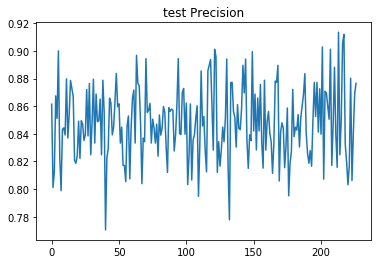

average : 0.8480350033801632
-10average : 0.8456925407551161
max : 0.9135135135135135


In [25]:
#Draw test precision
import numpy as np
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib
precision_data = np.load("./saver_data/conv_bn_lr_01/Precision_relu_test_rate_0_5.npz")
plot_x=range(len(precision_data['x']))
plot_y=precision_data['y']

plt.title('test Precision')
plt.plot(plot_x,plot_y)
plt.show()
print ('average : '+str(np.average(precision_data['y'])))
print ('-10average : '+str(np.average(precision_data['y'][-10:])))
print ('max : '+str(np.max(precision_data['y'])))


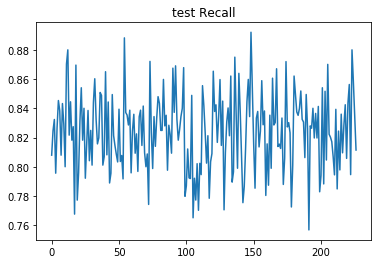

average : 0.8239091755108408
-10average : 0.8355577333336864
max : 0.8920454545454546


In [26]:
#Draw test Recall
%matplotlib inline


import matplotlib.pyplot as plt
import matplotlib
recall_data = np.load("./saver_data/conv_bn_lr_01/Recall_relu_test_rate_0_5.npz")
plot_x=range(len(recall_data['x']))
plot_y=recall_data['y']

plt.title('test Recall')
plt.plot(plot_x,plot_y)
plt.show()
print ('average : '+str(np.average(recall_data['y'])))
print ('-10average : '+str(np.average(recall_data['y'][-10:])))
print ('max : '+str(np.max(recall_data['y'])))


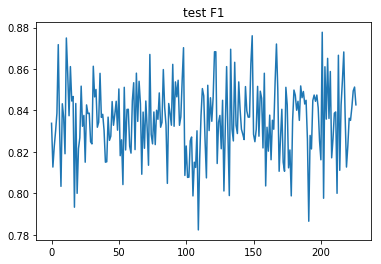

average : 0.8353628886831906
-10average : 0.8397700195880955
max : 0.8777777777777779


In [27]:
#Draw test F1
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib
f1_data = np.load("./saver_data/conv_bn_lr_01/F1_relu_test_rate_0_5.npz")
plot_x=range(len(f1_data['x']))
plot_y=f1_data['y']

plt.title('test F1')
plt.plot(plot_x,plot_y)
plt.show()
print ('average : '+str(np.average(f1_data['y'])))
print ('-10average : '+str(np.average(f1_data['y'][-10:])))
print ('max : '+str(np.max(f1_data['y'])))

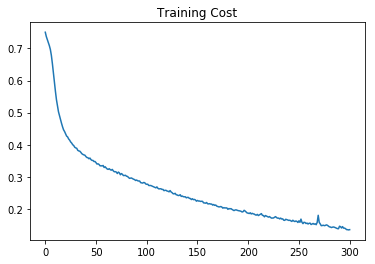

average : 0.25855371553217127
-10average : 0.13887622497537558
min : 0.13452651165425775


In [28]:
#Draw traing Cost
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib
cost_data = np.load("./saver_data/conv_bn_lr_01/Cost_relu_training_rate_0_5.npz")
plot_x=range(len(cost_data['x']))
plot_y=cost_data['y']

plt.title('Training Cost')
plt.plot(plot_x,plot_y)
plt.show()
print ('average : '+str(np.average(cost_data['y'])))
print ('-10average : '+str(np.average(cost_data['y'][-10:])))
print ('min : '+str(np.min(cost_data['y'])))


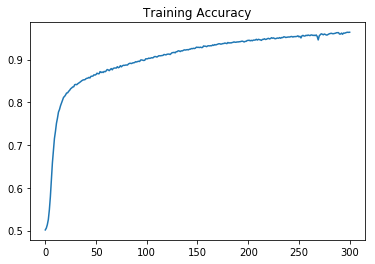

average : 0.904282627316025
-10average : 0.962303642805885
max : 0.9640040127670059


In [29]:
#Draw traing Cost
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib
#Draw Acc training
acc_data = np.load("./saver_data/conv_bn_lr_01/Acc_relu_training_rate_0_5.npz")
plot_x=range(len(acc_data['x']))
plot_y=acc_data['y']

plt.title('Training Accuracy')
plt.plot(plot_x,plot_y)
plt.show()
print ('average : '+str(np.average(acc_data['y'])))
print ('-10average : '+str(np.average(acc_data['y'][-10:])))
print ('max : '+str(np.max(acc_data['y'])))


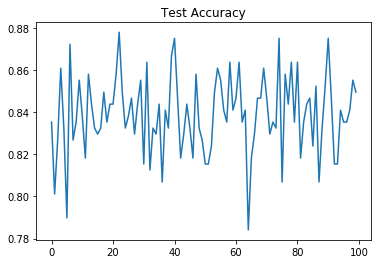

average : 0.8389773
-10average : 0.8389773
max : 0.87784094


In [30]:

#Draw traing Cost
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib
#Draw Acc test
acc_data = np.load("./saver_data/conv_bn_lr_01/Acc_relu_test_rate_0_5.npz")
plot_x=range(len(acc_data['x'][-100:]))
plot_y=acc_data['y'][-100:]

plt.title('Test Accuracy')
plt.plot(plot_x,plot_y)
plt.show()
print ('average : '+str(np.average(acc_data['y'][-100:])))
print ('-10average : '+str(np.average(acc_data['y'][-100:])))
print ('max : '+str(np.max(acc_data['y'][-100:])))

In [31]:
# #Draw traing Cost
# %matplotlib inline

# import matplotlib.pyplot as plt
# import matplotlib
# #Draw Acc test
# acc_data = np.load("D:/saver_data/relu_bn_0_5_L2/Acc_relu_test_rate_0_5.npz")
# plot_x=range(len(acc_data['x']))
# plot_y=acc_data['y']

# plt.title('Test Accuracy')
# plt.plot(plot_x,plot_y)
# plt.show()
# print ('average : '+str(np.average(acc_data['y'])))
# print ('-10average : '+str(np.average(acc_data['y'])))
# print ('max : '+str(np.max(acc_data['y'])))